In [36]:
import pandas as pd
import random
import math
import numpy as np
import operator
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt

In [37]:
#function to load the dataframe from the csv file
def loadCsv (filename):
    df=pd.read_csv(filename)#load the csv file
    df1=df.drop(['Unnamed: 0','galex_objid','sdss_objid','pred'],axis=1)#drop the required columns
    #print(df1.head())
    dataset=[]#a 2D list 
    for ind,row in df1.iterrows():#iterate through the dataframe
        dataset.append(row.values.tolist()) #store every row in the dataframe as a list.
    for i in range(len(dataset)):
        dataset[i] = [float(x) for x in dataset[i]] #typecast from string to float
    return dataset

#function to split the data according to the split ratio
def splitData(dataset,sRatio):
    trainSize = int(len(dataset)*sRatio) #calculate the length of the training dataset
    trainSet = []
    index=0
    count=1
    copy = list(dataset)
    while len(trainSet) < trainSize:
        index = random.randrange(len(copy)) #generate a random number to choose the training datapoint
        trainSet.append(copy.pop(index))# popping ensures the datapoints arent repeated
    return [trainSet,copy] #return the training and the test data

#function to upsample the dataset
def upsampling(dataset):
    trainSize = int(len(dataset))
    trainset_0 = [] #list of datapoints that belongs to class 0
    trainset_1 = [] #list of datapoints that belongs to class 1
    trainSet=[]
    index=0
    count=1
    copy = list(dataset)
    #append the datapoints to the lists according to their classes
    for i in range(len(copy)):
        if(copy[i][12]==1):
            trainset_1.append(copy[i]) 
        else:
            trainset_0.append(copy[i])
    leng=len(trainset_1)
    #for every point in class 1
    for i in range(leng):
        index = random.randrange(len(trainset_0)) #generate a random number within length of class 0
        #print(index)
        trainset_1.append(trainset_0[index]) #appened the element from class 0 to the list
    #The above loop ensues that the # of stars = # of quasars
    return trainset_1

In [50]:
#___ BAYESIAN ___#
class bayesian:
    def __init__(self,data,split):
        self.dataset=loadCsv(data) #load the csv file
        self.split=split #store the split ratio
        self.train,self.test = splitData(self.dataset,self.split) # split the dataset into train and test
        self.train = upsampling(self.train) #upsample the datapoints
        
        
    # function to divide the dataset based on its class    
    def classSplit(self,dataset):
        classdivision = {} # a dictionary with keys as class label and values as the remaining attributes
        for i in range(len(dataset)):
            v = dataset[i] #a particular row of the dataset
            if(v[12] not in classdivision):#check if the key is present
                classdivision[v[12]] = []
            classdivision[v[12]].append(v)
        return classdivision

    def trainfunc(self,dataset):
        classData = self.classSplit(dataset)
        PValues = {} #a dictionary to store mean stdev of all attributes classwise
        for classValue,instances in classData.items(): #returns a list of key,value pairs for tuples
            PValues[classValue] =[]
            for i in zip(*instances): #to parse the data columnwise
                mean = sum(i) / float(len(i)) #calculate the mean
                variance = math.sqrt(sum([pow(x-mean,2) for x in i]) / float(len(i)-1)) #calculate the variance
                PValues[classValue].append([mean,variance])
            del PValues[classValue][12:14] #drop the class labels and spectrometric redshifts from each row
        #print(PValues)
        return PValues

    #function to get the final probabilities
    def predictfunc(self,trainedModel,test):
        probabilities = {} #stores the probabilities classwise
        for val,mstd in trainedModel.items():
            probabilities[val] = 1 #initialise the probabilities to be 1
            for i in range (len(mstd)):
                    # guassian formula to calculate the probability
                    mean,stdev = mstd[i]
                    x = test[i]
                    e = math.exp(-(math.pow(x-mean,2) /(2*math.pow(stdev,2)))) 
                    const=1 / (math.sqrt(2*math.pi)*stdev)
                    probabilities[val] *=(e*const)
        #assign the class labels based on the probabilities.
        label,maxp = None,-1
        for classValue,probability in probabilities.items():
            if label is None or probability > maxp: #check which class higher probability
                maxp = probability
                label = classValue
        return label


    def predict(self):
            trainedModel = self.trainfunc(self.train) #Fitting model on training data
            predictions = []
            y_true = []
            redshift_1=[] #list containg the value of redshift for class 0
            redshift_2=[] #list containg the value of redshift for class 1
            for i in range(len(self.test)):
                result = self.predictfunc(trainedModel,self.test[i])
                predictions.append(result) #contains the predicted class labels
            for i in range(len(self.test)):
                vector = self.test[i]
                y_true.append(vector[12]) # contains the true class labels
                if(self.test[i][13]<0.004): #first threshold
                    redshift_1.append(0)
                else:
                    redshift_1.append(1)
                if(self.test[i][13]>0.0033): #second threshold
                    redshift_2.append(1)
                else:
                    redshift_2.append(0)


            #Generating confusion matrix for redshift with threshold 0.004
            cm_1 = confusion_matrix(predictions,redshift_1)
            FP = cm_1.sum(axis=0)-np.diag(cm_1)
            FN = cm_1.sum(axis=1)-np.diag(cm_1)
            TP = np.diag(cm_1)
            TN = cm_1.sum()-(FP+FN+TP)
            redshift_acc_1= (TP+TN) /(TP+TN+FP+FN)
            print('Accuracy for redshift (0.004 threshold) {} train-test split\n{}'.format(self.split,redshift_acc_1))

            #Generating confusion matrix for redshift with threshold 0.0033
            cm_2 = confusion_matrix(predictions,redshift_2)
            FP = cm_2.sum(axis=0)-np.diag(cm_2)
            FN = cm_2.sum(axis=1)-np.diag(cm_2)
            TP = np.diag(cm_2)
            TN = cm_2.sum()-(FP+FN+TP)
            redshift_acc_2= (TP+TN) /(TP+TN+FP+FN)     
            print('Accuracy for redshift (0.0033 threshold) {} train-test split\n{}'.format(self.split,redshift_acc_1))

            #Generating confusion matrix for overall accuracy
            cm = confusion_matrix(y_true,predictions)
            FP = cm.sum(axis=0)-np.diag(cm)
            FN = cm.sum(axis=1)-np.diag(cm)
            TP = np.diag(cm)
            TN = cm.sum()-(FP+FN+TP)

            accuracy = (TP+TN) /(TP+TN+FP+FN)
            #splitAcc.append(Accuracy)
            print('Accuracy for {} train-test split\n{}'.format(self.split,accuracy))
            return accuracy

In [51]:
#___ KNN ___#
class knn:
    def __init__(self,data,split):
        self.dataset=loadCsv(data) #load data file
        self.split=split #store split ratio
        self.train,self.test = splitData(self.dataset,self.split) #split into train and test
        self.train = upsampling(self.train) #upsample train
        
    #function to find euclidian distance
    def eud(self,a,b,length):
        dist = 0
        for i in range(length):
            if i==13:
                continue
            dist += pow((a[i]-b[i]), 2)
        return math.sqrt(dist)
    
    #Function to find k nearest neighbours
    def nb(self,train,test,k):
        d = []
        for i in range(len(train)): #for each point in the train set
            dist = self.eud(test,train[i],len(test)-1) #calling function to calculate distance
            d.append((train[i],dist))
        d.sort(key=operator.itemgetter(1))
        nei =[] #create list to store k nearest neighbours
        for i in range(k):
            nei.append(d[i][0]) #adding points that are closer
        return nei
    
    #function to check for majority class among neighbours 
    def res(self,neighbors):
        classVotes = {} #dictionary to store votes
        for i in range(len(neighbors)):
            response = neighbors[i][12] #actual value is stored in column 12
            if response in classVotes:
                classVotes[response] += 1
            else:
                classVotes[response] = 1
        sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1),reverse=True) #sorting to get majority vote
        return sortedVotes[0][0] #returning majority class
    
    #function to predict class
    def predict(self):
        #splitAcc=[]
        predictions =[]
        k=5
        y_true = []
        redshift_1=[]
        redshift_2=[]
        for j in range(len(self.test)): #iterating through test set
            nei = self.nb(self.train,self.test[j],k)
            result = self.res(nei)
            predictions.append(result) #storing predicted value
            y_true.append(self.test[j][12])  #storing actual value
            if(self.test[j][13]<0.004): #checking redshift threshold
                redshift_1.append(0)
            else:
                redshift_1.append(1)
            if(self.test[j][13]>0.0033):
                redshift_2.append(1)
            else:
                redshift_2.append(0)
                
        #Generating confusion matrix for redshift with threshold 0.004
        cm_1 = confusion_matrix(predictions,redshift_1)
        FP = cm_1.sum(axis=0)-np.diag(cm_1)
        FN = cm_1.sum(axis=1)-np.diag(cm_1)
        TP = np.diag(cm_1)
        TN = cm_1.sum()-(FP+FN+TP)
        redshift_acc_1= (TP+TN) /(TP+TN+FP+FN)
        print('Accuracy for redshift (0.004 threshold) {} train-test split\n{}'.format(self.split,redshift_acc_1))
        
        #Generating confusion matrix for redshift with threshold 0.0033
        cm_2 = confusion_matrix(predictions,redshift_2)
        FP = cm_2.sum(axis=0)-np.diag(cm_2)
        FN = cm_2.sum(axis=1)-np.diag(cm_2)
        TP = np.diag(cm_2)
        TN = cm_2.sum()-(FP+FN+TP)
        redshift_acc_2= (TP+TN) /(TP+TN+FP+FN)     
        print('Accuracy for redshift (0.0033 threshold) {} train-test split\n{}'.format(self.split,redshift_acc_1))
        
        #Generating confusion matrix for overall accuracy
        cm = confusion_matrix(y_true,predictions)
        FP = cm.sum(axis=0)-np.diag(cm)
        FN = cm.sum(axis=1)-np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum()-(FP+FN+TP)
        Precision = TP/(TP+FP)
        print('Precision\n{}'.format(Precision))
        Recall = TP/(TP+FN)
        print('Recall\n{}'.format(Recall))
        accuracy = (TP+TN) /(TP+TN+FP+FN)
        #splitAcc.append(Accuracy)
        print('Accuracy for {} train-test split\n{}'.format(self.split,accuracy))
        return accuracy

Bayesian model
Accuracy for redshift (0.004 threshold) 0.5 train-test split
[0.76 0.76]
Accuracy for redshift (0.0033 threshold) 0.5 train-test split
[0.76 0.76]
Accuracy for 0.5 train-test split
[0.76 0.76]
Accuracy for redshift (0.004 threshold) 0.6 train-test split
[0.74615385 0.74615385]
Accuracy for redshift (0.0033 threshold) 0.6 train-test split
[0.74615385 0.74615385]
Accuracy for 0.6 train-test split
[0.74615385 0.74615385]
Accuracy for redshift (0.004 threshold) 0.7 train-test split
[0.88205128 0.88205128]
Accuracy for redshift (0.0033 threshold) 0.7 train-test split
[0.88205128 0.88205128]
Accuracy for 0.7 train-test split
[0.87692308 0.87692308]
Accuracy for redshift (0.004 threshold) 0.8 train-test split
[0.76153846 0.76153846]
Accuracy for redshift (0.0033 threshold) 0.8 train-test split
[0.76153846 0.76153846]
Accuracy for 0.8 train-test split
[0.76153846 0.76153846]
Accuracy for redshift (0.004 threshold) 0.9 train-test split
[0.76923077 0.76923077]
Accuracy for redshif

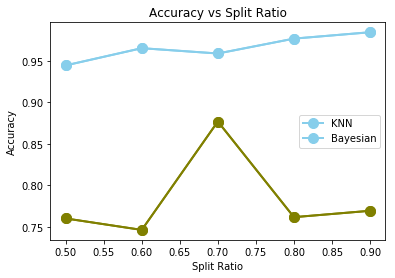

In [55]:
def main():
    knnAcc=[]
    bayesAcc=[]
    split = [0.5,0.6,0.7,0.8,0.9] #list of train-test split values
    
    print("Bayesian model")
    for i in split:
        model_baye=bayesian('cat1.csv',i) #creating an instance of bayesian class
        bayesAcc.append(model_baye.predict()) #calling predict function
    print("Average accuracy = ",sum(bayesAcc)/len(bayesAcc)) #average accuracy
    
    print("\nK-NN model")
    for i in split:
        model_knn=knn('cat1.csv',i) #creating an instance of knn class
        knnAcc.append(model_knn.predict()) #calling predict function
    print("Average accuracy = ",sum(knnAcc)/len(knnAcc)) #average accuracy
 
    #plotting a graph for accuracy
    ax = plt.subplot(111)
    ax.plot(split,knnAcc, marker='o',markersize=10, color='skyblue', linewidth=2)
    ax.plot(split,bayesAcc, marker='o', markersize=10,color='olive', linewidth=2)
    ax.legend(['KNN','Bayesian'])
    plt.xlabel("Split Ratio")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Split Ratio")
main()